# Preparação de Dados Para um Modelo de Classificação de CHURN de Uma Companhia de Telecomunicações

## Apresentação

A partir do conjunto de dados fornecido pelo site ***Maven Analytics*** que diz respeito a uma TELECOM, serão feitao uma análise exploratória, limpeza e transformação de dados, resultando em doiss diferentes arquivos csv: um voltado para a visualização em dashboards; e outro destinado a uma adaptação de modelo de classificação (ML) para tentar determinar se um cliente deixará de contratar o serviço fornecido pela empresa, o que é conhecido por CHURN.




## Datasets

Os 3 conjuntos de dados estão disponíveis na pasta do projeto. Eles são 3:

1) Uma tabela com informações detalhadas de clientes que já contrataram algum serviço

2) Uma tabela com a legenda dos nomes das colunas utilizadas na primeira

3) Uma tabela com os zipcodes de residência de cada cliente e sua respectiva população

Inicialmente, vamos carregar os datasets para conhecê-los melhor. O canho aqui descrito possui esse formato pois os arquivos foram carregados no Google Colab

In [14]:
#Importação de bibliotecas básicas necessárias para o desenvolvimento do projeto
import pandas as pd
import numpy as np

dados_clientes = pd.read_csv('telecom_customer_churn.csv')
zipcodes_populacao = pd.read_csv('telecom_zipcode_population.csv')
legendas = pd.read_csv('telecom_data_dictionary.csv')

In [15]:
#Como o nome das tabelas parece indicar, é possível associar a população de cada zipcode de um cliente a esse próprio cliente. 
#Ainda não é possível descartar que a população da região de um cliente influencia na sua permanência com a empresa ou não, então, 
#vamos unificar essas duas tabelas utilizando o zipcode como chave

print('Colunas dados_clientes', dados_clientes.columns)
print('Colunas zipcodes_populacao',zipcodes_populacao.columns)

Colunas dados_clientes Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')
Colunas zipcodes_populacao Index(['Zip Code', 'Population'], dtype='object')


In [16]:
#Unificando as duas tabelas:

dados_clientes = pd.merge(dados_clientes, zipcodes_populacao, on='Zip Code', how = 'left') 
#O parâmetro left permite não excluir nenhum cliente, ao mesmo tempo que ter um zipcode não associado a um cliente não nos interessa

dados_clientes.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Population
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,4498
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,31297
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,62069
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,46677
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,42853


In [17]:
#Agora, vamos eliminar algumas colunas que claramente não influenciam na decisão de um cliente permanecer ou não com a empresa
dados_clientes.drop(columns = ['Customer ID', #A identificação atribuída a um cliente é provavelmente desconhecida pelo próprio
                               'Zip Code', #Já temos a cidade onde o cliente reside, o que é equivalente
                               'Latitude', #Já temos a cidade onde o cliente reside, o que é equivalente (vamos desconsiderar problemas estritamente locais)
                               'Longitude', #Já temos a cidade onde o cliente reside, o que é equivalente (vamos desconsiderar problemas estritamente locais)
                               'Churn Category', #Pode enviesar os resultados sabermos de antemão a categoria na qual o cliente se encaixa
                               'Churn Reason', #Pode enviesar os resultados sabermos de antemão porque um cliente deixou de contratar os serviços
                               ], inplace = True)

In [18]:
#Agora, com relação às nossas labels, elas serão identificadas pela coluna 'Customer Status'. Porém há 3 categorias diferentes:
dados_clientes['Customer Status'].unique()

array(['Stayed', 'Churned', 'Joined'], dtype=object)

In [19]:
#Não estamos interessados em analisar clientes que acabaram de contratar um serviço, já que sequer tiveram tempo para poder deixar a empresa.
dados_clientes = dados_clientes[dados_clientes['Customer Status'] != 'Joined']
dados_clientes.reset_index(inplace = True,drop = True) #Reseta o index do dataframe, para evitar possíveis erros mais pra frente

#Além das colunas já eliminadas, temos a coluna que representará nossas labels para o modelo de classificação
y = dados_clientes['Customer Status']

#Agora podemos definir nossas features
x = dados_clientes.drop(columns = 'Customer Status')

## Limpeza de dados

### Dados nulos

In [20]:
#Primeiramente, vamos identificar se há alguma coluna com excesso de dados nulos
x.isnull().sum()

Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     644
Multiple Lines                        644
Internet Service                        0
Internet Type                        1344
Avg Monthly GB Download              1344
Online Security                      1344
Online Backup                        1344
Device Protection Plan               1344
Premium Tech Support                 1344
Streaming TV                         1344
Streaming Movies                     1344
Streaming Music                      1344
Unlimited Data                       1344
Contract                                0
Paperless Billing                 

In [21]:
#Consultando a tabela de legendas, é possível concluir que as colunas que possuem dados nulos são vinculadas à contratação de um serviço em específico,
#sendo ele telefone ou internet. Assim, vamos substituir os dados nulos por 'Não contratado' quando o tipo da coluna for string, e por 0 quando o tipo
#for numérico. Há apenas duas dessas colunas que são númericas. Vamos primeiro ajustar essas e depois ajustar o restante do dataframe como um todo
x.isnull().sum()[x.isnull().sum()>0].keys()

Index(['Avg Monthly Long Distance Charges', 'Multiple Lines', 'Internet Type',
       'Avg Monthly GB Download', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data'],
      dtype='object')

In [22]:
x['Avg Monthly Long Distance Charges'] = x['Avg Monthly Long Distance Charges'].fillna(0)
x['Avg Monthly GB Download'] = x['Avg Monthly GB Download'].fillna(0)
x = x.fillna('Não contratado')

#Uma alternativa seria eliminar essas colunas que dependem de outras para possui dados válidos. Porém, é possível que os clientes deixem a empresa justamente
#por causa de um desses serviços dependentes. Aqui optamos por manter essas colunas

In [26]:
dados_clientes.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents', 'City',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Population'],
      dtype='object')

### Dados com baixa variância

In [23]:
#Vamos separar as colunas em dois tipos: numéricas e categóricas nominais. 
#Para as primeiras, identificaremos as variâncias graficamente e eliminaremos os violinos simétricos

matriz_correlacao = x.corr()
colunas_numericas = list(matriz_correlacao.columns)
colunas_numericas_plot = colunas_numericas + ['Customer Status']

# Importa as bibliotecas necessárias para plotar um gráfico do tipo violinplot.
import seaborn as sns
import matplotlib.pyplot as plt

#Vamos transformar o dataframe 'dados_clientes' para que possamos plotar todas as variáveis simultaneamente
dados_plot = pd.melt(dados_clientes[colunas_numericas_plot], id_vars='Customer Status', 
                     value_vars=None, var_name='Variável', value_name='Valores', 
                     col_level=None, ignore_index=True)
dados_plot

,Customer Status,Variável,Valores
0,Stayed,Age,37.0
1,Stayed,Age,46.0
2,Churned,Age,50.0
3,Churned,Age,78.0
4,Churned,Age,75.0
...,...,...,...
85652,Churned,Population,42239.0
85653,Stayed,Population,44652.0
85654,Churned,Population,16525.0
85655,Stayed,Population,12173.0


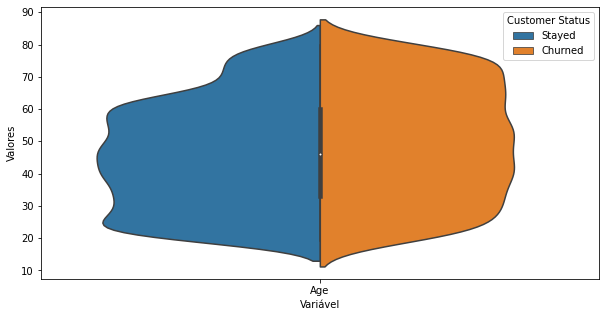

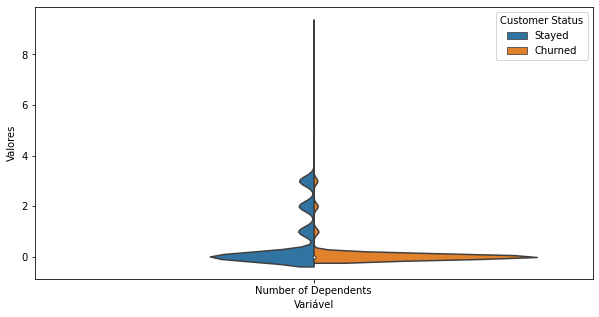

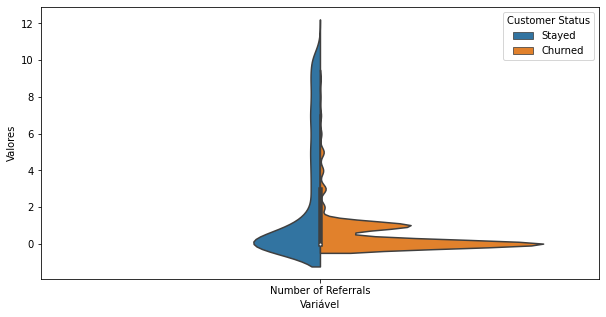

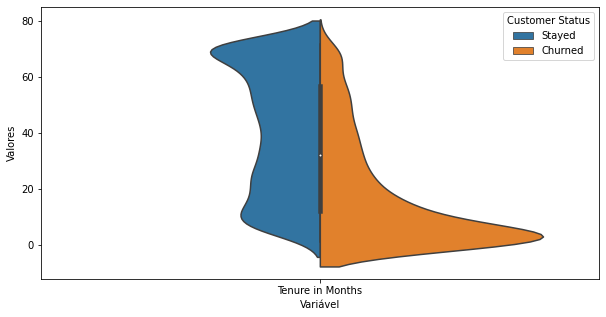

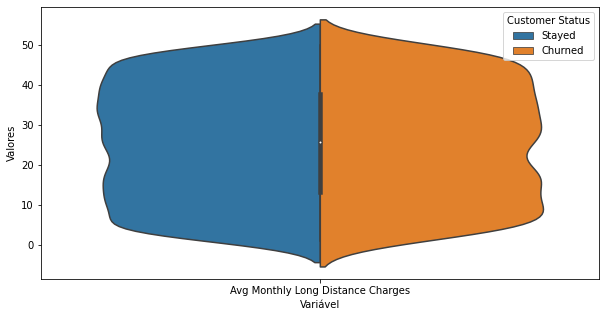

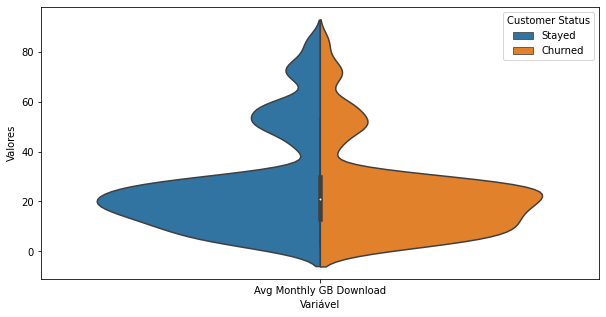

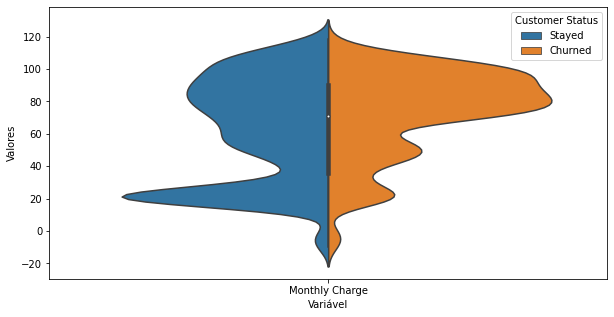

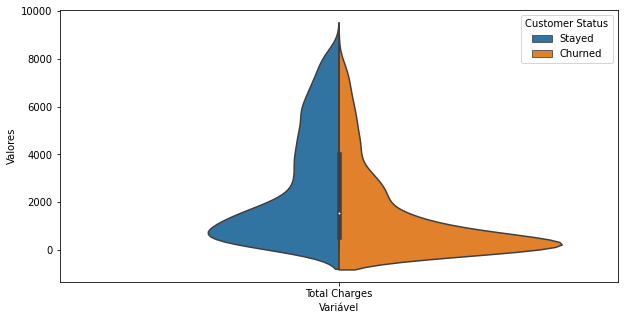

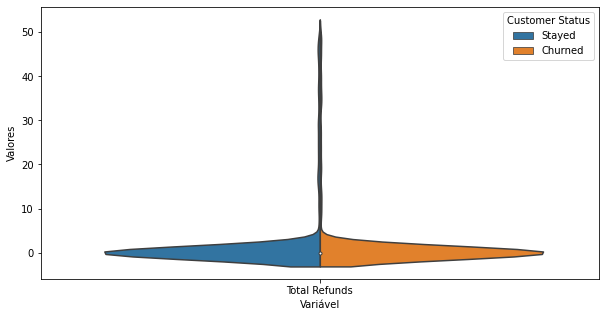

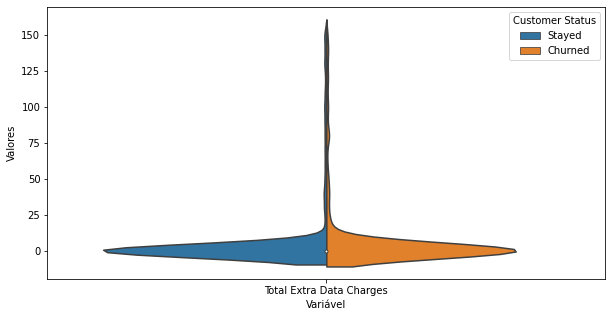

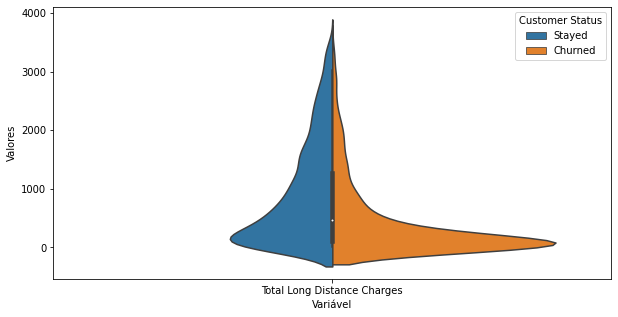

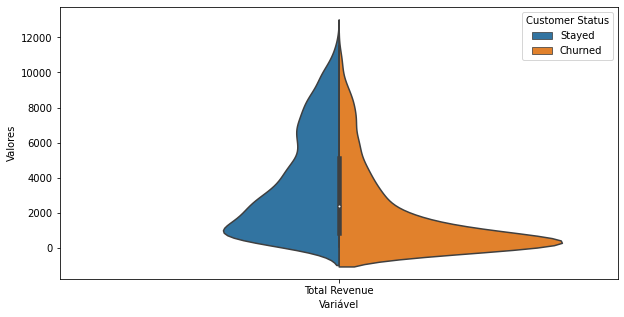

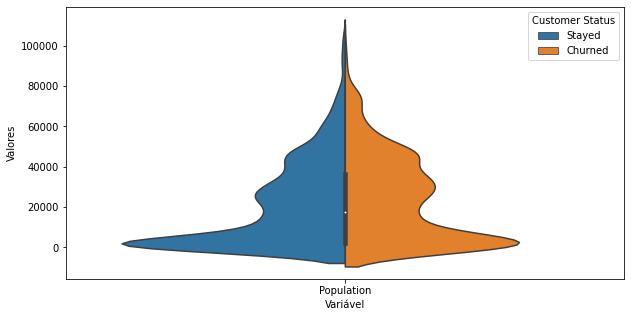

In [24]:
#Para não poluirmos as informações em apenas um gráfico, criaremos uma função para visualizar uma variável por vez (temos 13 colunas numéricas no total)

def plota_violino(variavel):

  plt.figure(figsize=(10, 5)) #Estabelece o tamanho do gráfico
  sns.violinplot(x = "Variável", y = "Valores", hue = "Customer Status",
                data = dados_plot[dados_plot['Variável'] == variavel], split = True,) #O parâmero split unifica as duas categorias em apenas um violino

for variavel in colunas_numericas:
  plota_violino(variavel)

In [25]:
#Podemos tirar algumas conclusões interessantes a respeito desses gráficos

#Age: até cerca de 60 anos aparenta uma simetria, depois disso há clara distinção para o CHURN. Talvez seja possível tornar essa variável binária
#Number of dependents: ligeiramente assimétrico
#Number of Referrals: assimétrico
#Tenure in Months: assimétrico
#Avg Monthly Long Distance Charges: simetria forte aparente
#Avg Monthly GB Download: simetria forte aparente
#Monthly Charge: assimétrico
#Total Charges: ligeiramente simétrico
#Total Refunds: semelhante à coluna 'Age', talvez possamos dividir os dados entre abaixo de 5 e acima ou igual a 5
#Total Extra Data Charges: simetria forte aparente
#Total Long Distance Charges: ligeiramente assimétrico
#Total Revenue: assimétrico
#Population: simetria forte aparente

#Uma alternativa talvez seja analisar matematicamente, para termos certeza de eliminar as colunas corretas:
dados_clientes[colunas_numericas_plot].groupby('Customer Status').var().transpose()

Customer Status,Churned,Stayed
Age,3.099322e+02,2.683865e+02
Number of Dependents,3.023918e-01,1.118988e+00
Number of Referrals,1.198295e+00,1.104848e+01
Tenure in Months,3.814648e+02,5.001339e+02
Avg Monthly Long Distance Charges,2.021107e+02,2.014365e+02
Avg Monthly GB Download,3.231080e+02,4.077617e+02
Monthly Charge,6.955754e+02,1.036760e+03
Total Charges,3.575212e+06,5.301938e+06
Total Refunds,4.958458e+01,7.236041e+01
Total Extra Data Charges,6.178875e+02,6.849115e+02


In [27]:
#Vamos então realizar as devidas modificações nas variáveis numéricas

#A coluna age será agora binária. 60 anos ou mais será representado por 1, e abaixo disso será representado por 0.
x['Age'] = x['Age'].apply(lambda x: 1 if x >= 60 else 0)

#A coluna Total Refunds será agora binária. 5 ou mais será representado por 1, e abaixo disso será representado por 0.
x['Total Refunds'] = x['Total Refunds'].apply(lambda x: 1 if x >= 5 else 0)

#As colunas 'Avg Monthly Long Distance Charges', 'Total Extra Data Charges' e 'Population' não e representam diferenças significativas entre os grupos. Logo, podemos retirá-las
x.drop(columns = ['Avg Monthly Long Distance Charges', 'Total Extra Data Charges', 'Population'], inplace = True)

In [28]:
#Agora, vamos avaliar as variáveis categóricas
colunas_categoricas = list(x.columns[x.columns.isin(colunas_numericas) == False])

x[colunas_categoricas].describe()

,Gender,Married,City,Offer,Phone Service,Multiple Lines,Internet Service,Internet Type,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method
count,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589,6589
unique,2,2,1106,6,2,3,2,4,3,3,3,3,3,3,3,3,3,2,3
top,Male,Yes,San Diego,None,Yes,No,Yes,Fiber Optic,No,No,No,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal
freq,3312,3318,278,3598,5945,3019,5245,2934,3272,2870,2855,3248,2658,2683,2809,4521,3202,3974,3728


In [29]:
#Precisamos identificar quais os valores únicos para cada coluna, para talvez transformá-las em binárias
for coluna in colunas_categoricas:
  print(coluna, x[coluna].unique())

Gender ['Female' 'Male']
Married ['Yes' 'No']
City ['Frazier Park' 'Glendale' 'Costa Mesa' ... 'Kirkwood' 'Carpinteria'
 'Meadow Valley']
Offer ['None' 'Offer E' 'Offer D' 'Offer A' 'Offer B' 'Offer C']
Phone Service ['Yes' 'No']
Multiple Lines ['No' 'Yes' 'Não contratado']
Internet Service ['Yes' 'No']
Internet Type ['Cable' 'Fiber Optic' 'DSL' 'Não contratado']
Online Security ['No' 'Yes' 'Não contratado']
Online Backup ['Yes' 'No' 'Não contratado']
Device Protection Plan ['No' 'Yes' 'Não contratado']
Premium Tech Support ['Yes' 'No' 'Não contratado']
Streaming TV ['Yes' 'No' 'Não contratado']
Streaming Movies ['No' 'Yes' 'Não contratado']
Streaming Music ['No' 'Yes' 'Não contratado']
Unlimited Data ['Yes' 'No' 'Não contratado']
Contract ['One Year' 'Month-to-Month' 'Two Year']
Paperless Billing ['Yes' 'No']
Payment Method ['Credit Card' 'Bank Withdrawal' 'Mailed Check']


In [30]:
#Bom, a princípio, a coluna 'City' também pode ser eliminada, já que possui um alto número de cidades distintas para proporcionalmente baixa quantidade total de dados (média de 6 clientes por cidade).
#Logo, a maior parte das cidades trará informações estatisticamente irrelevantes
x.drop(columns = 'City', inplace = True)

In [31]:
#As colunas 'Offer', 'Internet Type', 'Contract' e 'Payment Method' precisam ser analisadas mais a fundo. Se encontrarmos uma uniformidade nos dados, podemos descartá-las.
df_analise_categ = pd.concat([x[['Offer', 'Internet Type', 'Contract', 'Payment Method']],dados_clientes['Customer Status']],axis = 1)

#Podemos converter o dataframe em variáveis binárias e depois agruparmos 
df_analise_categ_dummy = pd.get_dummies(df_analise_categ)

df_analise_categ_dummy.head()

,Offer_None,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Internet Type_Não contratado,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check,Customer Status_Churned,Customer Status_Stayed
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1
1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1
2,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
3,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0


In [32]:
#Podemos analisar a porcentagem de CHURN em cada nova coluna. Se as porcentagens forem semelhantes, eliminamos toda a cetegoria de uma vez
df_analise_churn = df_analise_categ_dummy.sum().to_frame()
df_analise_churn.columns = ['Total']

df_analise_churn_b = df_analise_categ_dummy[df_analise_categ_dummy['Customer Status_Churned'] == 1].sum().to_frame()
df_analise_churn_b.columns = ['CHURN']

df_analise_churn = pd.concat([df_analise_churn,df_analise_churn_b],axis = 1)
df_analise_churn['% CHURN'] = df_analise_churn['CHURN']/df_analise_churn['Total']
df_analise_churn

,Total,CHURN,% CHURN
Offer_None,3598,1051,0.292107
Offer_Offer A,520,35,0.067308
Offer_Offer B,824,101,0.122573
Offer_Offer C,415,95,0.228916
Offer_Offer D,602,161,0.267442
Offer_Offer E,630,426,0.676190
Internet Type_Cable,774,213,0.275194
Internet Type_DSL,1537,307,0.199740
Internet Type_Fiber Optic,2934,1236,0.421268
Internet Type_Não contratado,1344,113,0.084077


In [33]:
#Os tipos de ofertas, de conexão de internet, de contrato e de método de pagamento variam bastante com relação ao percentual de CHURN. Logo, não é interessante eliminar essas variáveis.
#Unificando os dataframes resultantes:
colunas_categoricas.remove('City')
x = pd.concat([x.drop(columns = colunas_categoricas),df_analise_categ_dummy.iloc[:,:-2]], axis = 1)

## Avaliando a correlação

In [34]:
#O objetivo aqui é eliminar variáveis fortemente correlacionadas, já que para um modelo de classificação elas seriam apenas repetições de informação
matriz_correlacao = x.corr()
matriz_correlacao_v1 = matriz_correlacao[matriz_correlacao>0.9] #Aplica uma lógica bolleana sobre a matriz de correlação
matriz_correlacao_v2 = matriz_correlacao_v1.sum() #Evidencia as variáveis correlacionadas fortemente (terão a soma maior do que 1)
variaveis_correlacionadas = matriz_correlacao_v2[matriz_correlacao_v2>1]
colunas_eliminadas = variaveis_correlacionadas.keys() #Evidencia as variáveis correlacionadas
colunas_eliminadas

Index(['Total Charges', 'Total Revenue'], dtype='object')

In [35]:
#Vamos eliminar a coluna 'Total Charges' (escolha arbitrária)
x.drop(columns = 'Total Charges',inplace = True)

In [36]:
#Antes de iniciar o modelo em si, falta apenas converter nossas labels em 0 e 1
y = y.apply(lambda x: 1 if x == 'Churned' else 0)

## Conversão em csv

In [41]:
#Chegamos ao final de nossa preparação de dados para um projeto em ML. Vamos salvá-lo em csv:

df_ml = pd.concat([x,y],axis = 1)
df_ml.to_csv('dados_churn_ml.csv')

from google.colab import files
files.download("dados_churn_ml.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>